# __Analysis of QM/MM and ML/MM scans__
Manual task needed: collect all scan results (.csv for QM/MM scans and ??? for ML/MM scans) and place them in the results subfolder (same directory as this notebook)

In [9]:
import numpy as np
import re

# plotting
import matplotlib.pyplot as plt
plt.style.use('default')
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
rc('lines', lw=1, color='b')
rc('legend', loc='best')
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.edgecolor"] = 'black'
plt.rcParams['legend.borderpad'] = 0.25
plt.rcParams['legend.fontsize'] = 11
plt.rcParams.update({'pgf.preamble': r'\usepackage{amsmath}'})

R = 8.31446261815324
T = 300

In [12]:
def get_scans():
    '''
    Obtains all potential energy scans filenames (.csv for QM/MM and ??? for ML/MM)

    returns: List of filenames (input to plot_E_scans)
    '''

    return 0


def analyze_E_scans(csv_list, txt_name='', CH_OH_distances=False):
    '''
    Analyzes the scans to obtain Delta E and Delta E^\ddag. Stores it in analysis.txt
    '''

    # create data file
    if txt_name != '':
        with open(txt_name+'_readable.txt', 'w') as f:
            pass
        with open(txt_name+'.txt', 'w') as f:
            f.write('# FRAME'.ljust(15)+'Delta Eddag'.ljust(15)+'Delta E'.ljust(15)+'\n')

    # data list
    raw_data_1 = [np.genfromtxt(csv, delimiter=',') for csv in csv_list]
    
    rc_list = []
    energy_list = []
    TS_energy_list = []
    CH_dist_list = []
    OH_dist_list = []

    for i in range(len(raw_data_1)):

        # get data for a single scan
        data = raw_data_1[i]

        # get rc and energy
        _rc = data[1:, 1]
        _energy_hartree = data[1:, 2] / 627.509     # hartree
        _delta_E = data[1:, 3]                      # kcal/mol
        rc_list.append(_rc)
        energy_list.append(_delta_E)

        # get reactant energy
        _delta_E_reactant = []
        for j in range(len(_rc)):
            if _rc[j] < 0:
                _delta_E_reactant.append(_delta_E[j])

        max_index = np.argmax(_energy_hartree)
        min_index = np.argmin(_energy_hartree)
        reactant_minimum = np.argmin(_delta_E_reactant)
        
        _delta_E_reactant_kcalmol = _delta_E[max_index] - _delta_E[reactant_minimum]
        TS_energy_list.append(_delta_E_reactant_kcalmol)

        _delta_E_product_kcalmol = _delta_E[min_index] - _delta_E[reactant_minimum]

        # save to file
        if txt_name != '':
            with open(txt_name+'_readable.txt', 'a') as f:
                f.write(f'{csv_list[i]}\n')
                f.write(f'Max energy frame:'.ljust(20)+f'{max_index+1}\n')
                #f.write(f'Lowest energy reactant:\t{_delta_E[reactant_minimum]}\n')
                #print(f'QM/MM energy (max):  \t{_energy_hartree[max_index]:.6f}\tHartree')
                #print(r'\Delta E\ddag'+f':        \t{_delta_E[max_index]:.3f}       \tkcal/mol')
                f.write(r'\Delta E\ddag:'.ljust(20)+f'{_delta_E_reactant_kcalmol:.3f}       \tkcal/mol\n')
                #print(f'QM/MM energy (min):  \t{_energy_hartree[max_index]:.6f}\tHartree')
                #print(r'\D'+f'elta E:        \t{_delta_E[min_index]:.3f}       \tkcal/mol')
                f.write(r'\Delta E:'.ljust(19)+f'{_delta_E_product_kcalmol:.3f}       \tkcal/mol\n\n')



            with open(txt_name+'.txt', 'a') as f:
                f.write(f'{re.findall(r'\d+', csv_list[i])[-1]}'.ljust(15)+f'{_delta_E_reactant_kcalmol:.3f}'.ljust(15)+f'{_delta_E_product_kcalmol:.3f}\n')

        # reaction coordinate CH and OH distances (used to plot RC)
        CH_distances = data[1:, 4]
        CH_dist_list.append(CH_distances)
        OH_distances = data[1:, 5]
        OH_dist_list.append(OH_distances)

    # compute exponential average contribution to Delta G
    n = len(TS_energy_list)

    EA = 0
    for deltaE in TS_energy_list:
        EA += np.exp((- deltaE * 4.184 * 1000)/(R * T))
    DeltaG_EA = - R * T * np.log(1/n * EA) / (4.184 * 1000)     # in kcal/mol

    with open(txt_name+'_readable.txt', 'a') as f:
        f.write(f'\n# EA contribution to DeltaG from the above scans (kcal/mol)\n')
        f.write(f'{DeltaG_EA:.3f}')


    if CH_OH_distances:
        return rc_list, energy_list, CH_dist_list, OH_dist_list
    else: 
        return rc_list, energy_list 
    

def plot_E_scans(qmmm_csv_list, mlmm_csv_list=None, add_info_qmmm=[], add_info_mlmm=[], title_qmmm='', title_mlmm=''):
    '''
    Plot potential energy E vs. Reaction Coordinate. 

    .csv or .txt files must be provided as a list of filenames.

    csv_list: if only QM/MM or ML/MM
    csv_list_2: used for comparison [in this case csv_list is for QM/MM and csv_list_2 for ML/MM]
    '''

    # color lists
    colors_qmmm = ['deeppink', 'pink', 'darkred', 'lightcoral', 'darkgoldenrod', 'palegoldenrod']
    colors_mlmm = ['darkgreen', 'mediumaquamarine',  'darkblue', 'cornflowerblue', 'darkviolet', 'plum']

    # only use QM/MM inputs 
    if mlmm_csv_list is None:

        # preprocess QM/MM data
        qm_rc_list, qm_energy_list = analyze_E_scans(qmmm_csv_list, txt_name='analysis_qmmm.txt')

        ncols = 1
        fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(4.5*ncols, 4))
        ax1 = axes
        
        ax1.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
        ax1.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")
        
        for i in range(len(qm_rc_list)):

            ax1.plot(qm_rc_list[i], qm_energy_list[i], color=colors_qmmm[i], alpha=0.9, label=r'$\textnormal{' +f'{add_info_qmmm[i]},  {re.findall(r'\d+', qmmm_csv_list[i])[-1]}' + r'}$')
            
        ax1.set(xlabel=r'$\textnormal{Reaction coordinate}\;\Delta r = r_{\textnormal{CH}}-r_{\textnormal{HO}}$', ylabel=r'$\Delta E\;\;(\textnormal{kcal mol}^{-1})$') 
        
        if title_qmmm != '':
            ax1.legend(loc='lower left', prop={'size': 10}, title=r'$\textsf{'+f'{title_qmmm}'+r'}$', title_fontsize=10)            
        else:
            ax1.legend(loc='lower left', prop={'size': 10}, title=r'$\textsf{'+f'QM/MM scans'+r'}$', title_fontsize=10)

        # TODO customization              
        #axes.set_xlim(-3, 3)
        #if y_lim_inf is not None:
        #    axes.set_ylim(bottom=y_lim_inf)
    
        plt.tight_layout()
        plt.savefig(f'analysis_qm.png', dpi=400)
        plt.show(fig)


    # plot QM/MM and ML/MM scans side by side
    else:
        # preprocess QM/MM data
        qm_rc_list, qm_energy_list = analyze_E_scans(qmmm_csv_list, txt_name='analysis_qmmm')

        # preprocess ML/MM data
        ml_rc_list, ml_energy_list = analyze_E_scans(mlmm_csv_list, txt_name='analysis_mlmm')

        ncols = 2
        fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(4.5*ncols, 4))
        ax1, ax2 = axes
        
        ax1.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
        ax1.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")
        ax2.tick_params(bottom=True, top=True, left=True, right=True, direction="in")
        ax2.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False, direction="in")
        
        for i in range(len(qm_rc_list)):
            if len(add_info_qmmm) != 0 and len(add_info_mlmm) != 0:
                ax1.plot(qm_rc_list[i], qm_energy_list[i], color=colors_qmmm[i], alpha=0.9, label=r'$\textnormal{' +f'{add_info_qmmm[i]},  {re.findall(r'\d+', qmmm_csv_list[i])[-1]}' + r'}$')
                ax2.plot(ml_rc_list[i], ml_energy_list[i], color=colors_mlmm[i], alpha=0.9, label=r'$\textnormal{' +f'{add_info_mlmm[i]},  {re.findall(r'\d+', mlmm_csv_list[i])[-1]}' + r'}$')
            else:
                ax1.plot(qm_rc_list[i], qm_energy_list[i], color=colors_qmmm[i], alpha=0.9, label=r'$\textnormal{' +f'{re.findall(r'\d+', qmmm_csv_list[i])[-1]}' + r'}$')
                ax2.plot(ml_rc_list[i], ml_energy_list[i], color=colors_mlmm[i], alpha=0.9, label=r'$\textnormal{' +f'{re.findall(r'\d+', mlmm_csv_list[i])[-1]}' + r'}$')

        ax1.set(xlabel=r'$\textnormal{Reaction coordinate}\;\Delta r = r_{\textnormal{CH}}-r_{\textnormal{HO}}$', ylabel=r'$\Delta E\;\;(\textnormal{kcal mol}^{-1})$') 
        ax2.set(xlabel=r'$\textnormal{Reaction coordinate}\;\Delta r = r_{\textnormal{CH}}-r_{\textnormal{HO}}$', ylabel=r'$\Delta E\;\;(\textnormal{kcal mol}^{-1})$') 

        if title_qmmm != '':
            ax1.legend(loc='lower left', prop={'size': 9}, title=r'$\textsf{'+f'{title_qmmm}'+r'}$', title_fontsize=9)
            
        if title_mlmm != '':
            ax2.legend(loc='lower left', prop={'size': 9}, title=r'$\textsf{'+f'{title_mlmm}'+r'}$', title_fontsize=9)
        else:
            ax1.legend(loc='lower left', prop={'size': 9}, title=r'$\textsf{'+f'QM/MM scans'+r'}$', title_fontsize=8)
            ax2.legend(loc='lower left', prop={'size': 9}, title=r'$\textsf{'+f'ML/MM scans'+r'}$', title_fontsize=8)
                  
        # TODO customization              
        #axes.set_xlim(-3, 3)
        #if y_lim_inf is not None:
        #    axes.set_ylim(bottom=y_lim_inf)
    
        plt.tight_layout()
        plt.savefig(f'analysis_qm_vs_ml.png', dpi=400)
        plt.show(fig)



def plot_rc(csv_path):
    # data list
    
    rc_list, energy_list, ch_list, oh_list = analyze_E_scans([csv_path], txt_name='', CH_OH_distances=True)
    _rc = rc_list[0]
    _delta_E = energy_list[0]
    _ch = ch_list[0]
    _oh = oh_list[0]

    # generate time figure
    ncols = 2
    fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(4.5*ncols, 4))

    for j in range(ncols):
        if j==0:
            axes[j].tick_params(bottom=True, top=True, left=True, right=False,direction="in")
            axes[j].tick_params(labelbottom=True, labeltop=False, labelleft=True,labelright=False, direction="in")
            axes[j].plot(_rc, _delta_E, color='black', alpha=0.9)
            
            axes[j].set(xlabel=r'$\textnormal{Reaction coordinate}\;\Delta r = r_{\textnormal{CH}}-r_{\textnormal{HO}}$', ylabel=r'$\Delta E\;\;(\textnormal{kcal mol}^{-1})$')

        if j==1:
            axes[j].tick_params(bottom=True, top=True, left=True, right=False,direction="in")
            axes[j].tick_params(labelbottom=True, labeltop=False, labelleft=True,labelright=False, direction="in")
                
            axes[j].plot(_rc, _ch, color='darkgreen', alpha=0.9, label=r'$\textnormal{'+f'C--H'+r' }$')
            axes[j].plot(_rc, _oh, color='deeppink', alpha=0.9, label=r'$\textnormal{'+f'H--O'+r' }$')
            
            axes[j].set(xlabel=r'$\textnormal{Reaction coordinate}\;\Delta r = r_{\textnormal{CH}}-r_{\textnormal{HO}}$', ylabel=r'$\textnormal{Distance (Å)}$')
            axes[j].legend(loc='best', prop={'size': 10}, title=r'$\textsf{'+f'Distance'+r'}$', title_fontsize=11)

    plt.tight_layout()
    plt.savefig(f'analysis_rc_sample.png', dpi=400)
    plt.show(fig)

<>:12: SyntaxWarning: invalid escape sequence '\d'
<>:12: SyntaxWarning: invalid escape sequence '\d'
/var/folders/cq/s30xmbh57xndgmhg1zhwclsh0000gn/T/ipykernel_31715/1251852729.py:12: SyntaxWarning: invalid escape sequence '\d'
  '''


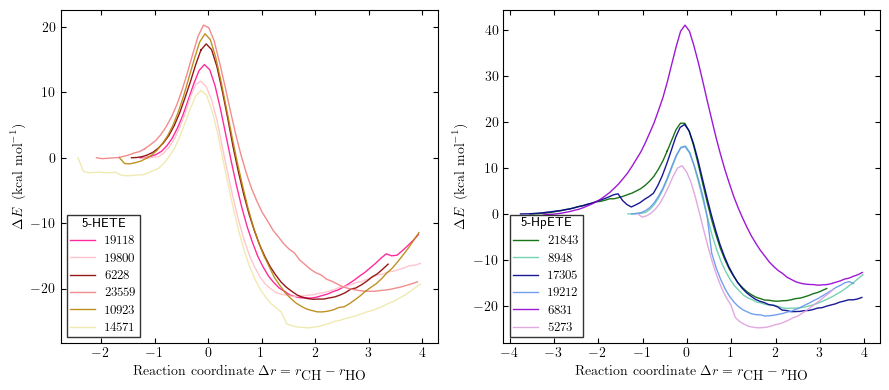

In [13]:
add_info_qmmm = [r'C$_{10}$, 185', r'C$_{13}$, 185', r'C$_{10}$, 343', r'C$_{13}$, 343', r'C$_{10}$, 284', r'C$_{13}$, 284',]
qmmm_csv_list = ['PES_result_scan_rc_19118.csv', 'PES_result_scan_rc_19800.csv', 'PES_result_scan_rc_6228.csv', 'PES_result_scan_rc_23559.csv', 'PES_result_scan_rc_10923.csv', 'PES_result_scan_rc_14571.csv']

add_info_mlmm = [r'C$_{10}$, 41', r'C$_{13}$, 41', r'C$_{10}$, 369', r'C$_{13}$, 369', r'C$_{10}$, 19', r'C$_{13}$, 19']
mlmm_csv_list = ['PES_result_scan_rc_21843.csv', 'PES_result_scan_rc_8948.csv', 'PES_result_scan_rc_17305.csv', 'PES_result_scan_rc_19212.csv', 'PES_result_scan_rc_6831.csv', 'PES_result_scan_rc_5273.csv']

#plot_E_scans(qmmm_csv_list, mlmm_csv_list, add_info_qmmm, add_info_mlmm, title_qmmm='5-HETE', title_mlmm='5-HpETE')
plot_E_scans(qmmm_csv_list, mlmm_csv_list, title_qmmm='5-HETE', title_mlmm='5-HpETE')

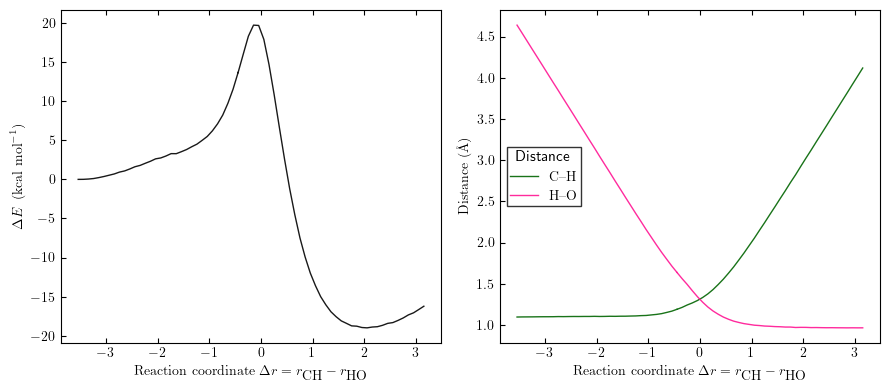

In [ ]:
plot_rc('PES_result_scan_rc_21843.csv')